# Modèles de taux 

In [116]:
#importation des modules
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import requests  # Connexion à l'API de AlphaVantage

In [117]:
#entrée des données
# Clé personnelle de l'API AlphaVantage
key_API = 'LYMJQ6KR5QPKJ8W3'
rate = 'FEDERAL_FUNDS_RATE'   # Choisissez n'importe quel taux
url = f'https://www.alphavantage.co/query?function={rate}&interval=monthly&apikey={key_API}'
r = requests.get(url)
data = r.json()
# Accédez à la clé 'data' dans le dictionnaire
data = data['data']

# Créez un tableau NumPy contenant toutes les valeurs
values = np.array([float(entry['value']) for entry in data])

In [118]:
# On suppose une volatilité constante (très faux)
ecart_type = np.std(values/100)
v = ecart_type * np.sqrt(12)
print(v)

0.12451431506042658


In [119]:
# Traitement des données 
data_ = values [731:]
X_train = data_ [:100]
X_test = data_ [50:]

### Modèle de Vasicek :

$$drt = a(k - rt)dt + \sigma dW(t)$$

$$r_{t + \delta} = r_t e^{-a\delta} + k(1 - e^{-a\delta}) + \sigma \sqrt{\frac{1 - e^{-2a\delta}}{2a}} \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, 1)$$


Remarque : Le modèle de Vasicek est approprié à une évaluation sur le court terme, les données mensuelles sont donc peut être pas exactement adaptées pour observer l'oscillation autour de k.

In [120]:
#loi normale que suit le taux dans le modèle de vasicek

def N_Vas(x,a,k,t,r):
    
    e = v * np.sqrt((1 - np.exp(-2 * a * t)) / (2 * a))
    
    esp = r * np.exp(-a * t) + k * (1 - np.exp(-a * t))
    
    return ((1 / (e * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - esp) / e)**2))

**Fonction de Vraisemblance :** (formule cas discret)
$$L(a, k) = P(X_1 = x_1) \cdot P(X_2 = x_2 \,|\, X_1 = x_1) \cdot \ldots \cdot P(X_n = x_n \,|\, X_{n-1} = x_{n-1})$$

**Fonction de log-Vraisemblance :**
$$\ln(L(a, k)) = \ln(P(X_1 = x_1)) + \ln(P(X_2 = x_2 | X_1 = x_1)) + \ldots + \ln(P(X_n = x_n | X_{n-1} = x_{n-1}))$$


In [139]:
#définissons maintenant la fonction de log vraisemblance

def log_vraisemblance_Vas(paramètres, X_train):
    a, k = paramètres
    S=0
    t=1/12
    for i in range (len(X_train)-1):
        P = N_Vas(X_train[i+1], a, k, t, X_train[i])
        S-=np.log(P)
    return(S)

In [140]:
log_vraisemblance_Vas([0.5, 1], X_train)

3560.9655110035283

In [143]:
# Estimation des paramètres avec la méthode MLE
# Contraintes
constraints = ({'type': 'ineq', 'fun': lambda params: np.exp(params[0])},  # a >= 0
               {'type': 'ineq', 'fun': lambda params: params[1]})  # k >= 0

resultat_estimation = minimize(log_vraisemblance_Vas, [1, 2], args=(X_train,), constraints=constraints)
parametres_estimes = resultat_estimation.x

/var/folders/28/1h3z3mcs1gxg23mnjw1zj_n00000gn/T/ipykernel_776/577570759.py:9: RuntimeWarning: divide by zero encountered in log
  S-=np.log(P)


In [144]:
# Affichage des paramètres estimés
a_estime, k_estime = parametres_estimes
print("Paramètre a estimé : ", a_estime)
print("Paramètre k estimé : ", k_estime)

Paramètre a estimé :  0.0649735941261259
Paramètre k estimé :  4.893400647986606e-16


In [147]:
#simulations de taux aléatoire 
A = []
B = []
C = []
t = 1/12

for k in range (len(X_test)):
    e = v * np.sqrt((1 - np.exp(-2 * a_estime * t)) / (2 * a_estime))
    esp = esp = X_test[k - 1] * np.exp(-a_estime * t) + k_estime * (1 - np.exp(-a_estime * t))

    tirage = np.random.normal(0, 1, 3)
    A.append(esp + e*tirage[0])
    B.append(esp + e*tirage[1])
    C.append(esp + e*tirage[2])


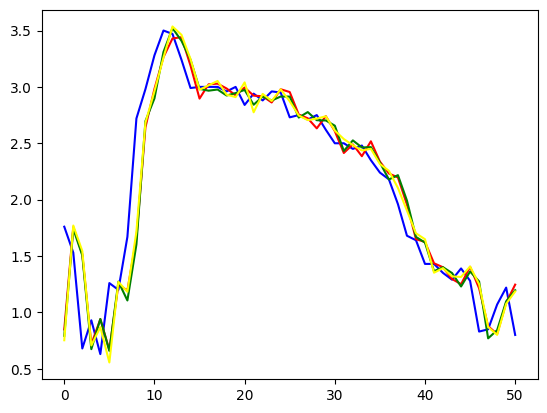

In [148]:
# Visualisation
abscisse=[i for i in range(len(X_test))]
plt.plot(abscisse, X_test, label='Données réelles', color='blue')
plt.plot(abscisse, A, label='Simulation 1', color='red')
plt.plot(abscisse, B, label='Simulation 2', color='green')
plt.plot(abscisse, C, label='Simulation 3', color='yellow')

**En conclusion :**

On remarque que la forme générale de la courbe des taux est respectée dans les trois simulations. Cependant, il est important de noter quelques irrégularités, notamment au début de la courbe. Ces irrégularités peuvent être attribuées au fait que le modèle de Vasicek est principalement conçu pour modéliser les taux à court terme. En effet le modèle de Vasicek présente une force de rappel vers k, au début de la courbe, le taux a une valeur clairement inférieure à k ce qui explique que la courbe monte au lieu de descendre.

Les données que j'ai utilisées sont échantillonnées de manière mensuelle, ce qui peut ne pas être idéal pour ce modèle, et la période sur laquelle les données s'étendent est peut-être trop longue pour une adaptation optimale du modèle.

## Modèle de Cox-Ingersoll-Ross (CIR) :

$$dr_t = a(k - r_t)dt + \sigma \sqrt{r_t} dW(t)$$

Il n'existe pas de solution explicite de cette EDS contrairement au modèle de Vasicek, on va donc utiliser une discrétisation et transformer l'outil différentiel par une 'petite' variation.

ie : $$\Delta r = a(k - r_t) \, \Delta t + \sigma \sqrt{r_t} \, \sqrt{\Delta t} \, \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, 1)$$


In [150]:
#loi normale que suit le taux dans le modèle CIR

def N_CIR(x, a, k, t, r):
    
    e = v * np.sqrt(r * t)
    
    esp = r + t * a * (k - r)
    
    return ((1 / (e * np.sqrt(2 * np.pi))) * np.exp(-0.5 * np.square((x - esp) / e)))

In [151]:
#définissons maintenant la fonction de log vraisemblance

def log_vraisemblance_CIR(paramètres, X_train):
    a, k = paramètres
    S=0
    t=1/12
    for i in range (len(X_train)-1):
        P = N_CIR(X_train[i+1], a, k, t, X_train[i])
        S-=np.log(P)
    return(S)

In [152]:
# Estimation des paramètres avec la méthode MLE
# Contraintes
constraints = ({'type': 'ineq', 'fun': lambda params: params[0]},  # a >= 0
               {'type': 'ineq', 'fun': lambda params: params[1]})  # k >= 0

resultat_estimation = minimize(log_vraisemblance_CIR, [4, 1], X_train, constraints=constraints)
parametres_estimes = resultat_estimation.x

/var/folders/28/1h3z3mcs1gxg23mnjw1zj_n00000gn/T/ipykernel_776/1319895807.py:9: RuntimeWarning: divide by zero encountered in log
  S-=np.log(P)


In [154]:
# Affichage des paramètres estimés
a_estime, k_estime = parametres_estimes
print("Paramètre a estimé : ", a_estime)
print("Paramètre k estimé : ", k_estime)

Paramètre a estimé :  1.1595006970999477
Paramètre k estimé :  2.301004852879645


In [158]:
#simulations de taux aléatoire 
A = []
B = []
C = []
t = 1/12

for k in range (len(X_test)):
    e = v * np.sqrt(X_test[k - 1] * t)
    esp = X_test[k - 1] + t * a_estime * (k_estime - X_test[k - 1])

    tirage = np.random.normal(0, 1, 3)
    A.append(esp + e*tirage[0])
    B.append(esp + e*tirage[1])
    C.append(esp + e*tirage[2])

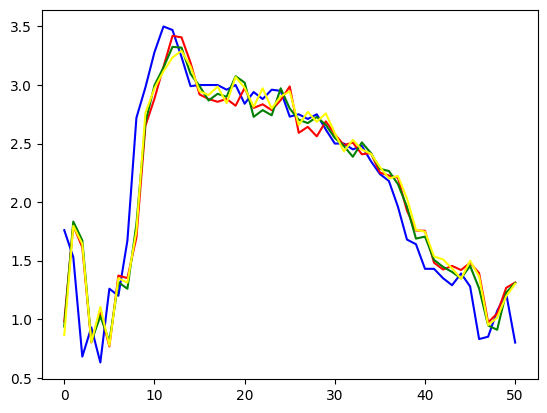

In [159]:
# Visualisation
abscisse=[i for i in range(len(X_test))]
plt.plot(abscisse, X_test, label='Données réelles', color='blue')
plt.plot(abscisse, A, label='Simulation 1', color='red')
plt.plot(abscisse, B, label='Simulation 2', color='green')
plt.plot(abscisse, C, label='Simulation 3', color='yellow')

**En conclusion :**

On retrouve, sur ces simulations, les mêmes caractéristiques que pour le modèle de Vasicek. Les simulations montrent des oscillations plus importantes que pour la courbe réelle (bleu), ce qui peut être à l'origine d'une erreur d'estimation sur le paramètre a (force de rappel).

Remarque : l'intérêt principal de ce modèle est que la partie aléatoire de l'EDS est 'majorée', ce qui permet d'éviter les valeurs négatives (phénomène possible mais non observé dans les simulations de Vasicek).